# Transmission line insulators
---
## Segmentation
Segmentation is performed using Unet.
Classification is implemented in part 2.

In [42]:
import os

# Downloading the dataset
if os.name != 'nt':
    !wget 'https://drive.google.com/uc?export=download&id=1j0EB_nsTbceHo2V0ZR_v_F_XnwkL4Kg8' -O data.zip
    !unzip -q data.zip
# elif os.name == 'nt':
#     print('Dataset: Use powershell script provided in directory \"download_data.ps1\".')
    
if os.name == 'posix':
  # Downloading model weights
  !wget 'https://drive.google.com/uc?export=download&id=13aXbjbThZl8gCQQ4HHpMgp-fnmCB3OTS' -O final_model_weights.zip
  !unzip -q final_model_weights.zip

  # Downloading tensorflow summaries
  !wget 'https://drive.google.com/uc?export=download&id=16Rh4PNuLiAKb3p8cxuxIzLkTd5oXH64X' -O summaries.zip
  !unzip -q summaries.zip
    
  # Downloading misc
  !wget 'https://drive.google.com/uc?export=download&id=1Cox4ygIhprBJcHcduRYQXkY46Fj4PQwa' -O misc.zip
  !unzip -q misc.zip
    

# Set data paths
data_path_seg = 'Dataset/Segmentation'
data_path_class = 'Dataset/Classification'

Dataset: Use powershell script provided in directory "download_data.ps1".


In [2]:
import importlib
module_spec = importlib.util.find_spec("google.colab")
module_exists = module_spec is not None

if module_exists:
    from google.colab import drive
    drive.mount('/content/drive')
    # drive.mount('/content/drive', force_remount = True)

In [3]:
### Visualize the data ###
# !pip install google-colab 
# !pip install albumentations

import math

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
rcParams['font.size'] = 14

import numpy as np
import skimage
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm    # run this in Colab
from tqdm import tqdm               # or this in Jupyter instead
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
device = "cuda"

import torchvision
from torchvision import transforms
import glob
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

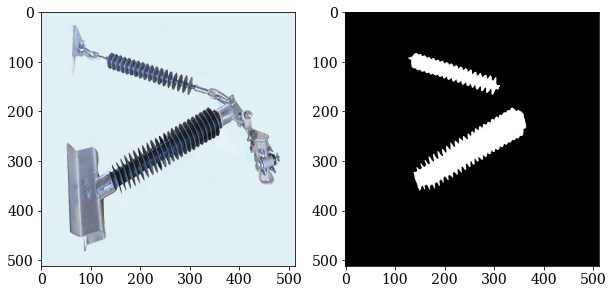

In [41]:
import cv2

# Insulators

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = io.imread(os.path.join(data_path_seg, 'train/in/1.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread(os.path.join(data_path_seg, 'train/gt/1.jpg')))
plt.imshow(mask)

In [204]:
# Intersection over union

def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).sum().float()
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).sum().float()
    return (intersection) / union

def calc_iou_torch(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += torch.sum(torch.mul(prediction, ground_truth))
        union += torch.sum(torch.max(prediction, ground_truth))
    #print("is: ", intersection, ",un: ", union)
    return torch.div(intersection,union)

In [198]:
class SegTrainDataset(Dataset):
    def __init__(self,transform = None, data_path = ""): 
        self.path1 = sorted(glob.glob(os.path.join(data_path, "train/in/*.jpg")))
        self.path2 = sorted(glob.glob(os.path.join(data_path, "train/gt/*.jpg")))
        assert len(self.path1) == len(self.path2)
        self.transform = transform
    def __getitem__(self, index):
        sample  = cv2.imread(self.path1[index])
        sample1 = cv2.imread(self.path2[index], 0)
        if self.transform is not None:
            augmented = self.transform(image = sample, mask = sample1)
            sample =  torch.tensor(augmented['image'], dtype = torch.float32) / 255
            sample1 = torch.tensor(augmented['mask'], dtype = torch.float32) / 255
        # sample1.unsqueeze_(0)
        # photo_image, map_image = torch.chunk(sample, chunks=2, dim=2)
        
        return sample, sample1
    def __len__(self):
        return len(self.path1)

class SegValDataset(Dataset):
    def __init__(self,transform = None, data_path = ""): 
        self.path1 = sorted(glob.glob(os.path.join(data_path, "val/in/*.jpg")))
        self.path2 = sorted(glob.glob(os.path.join(data_path, "val/gt/*.jpg")))
        self.transform=transform
    def __getitem__(self, index):
        sample = cv2.imread(self.path1[index])
        sample1=cv2.imread(self.path2[index], 0)
        if self.transform is not None:
            augmented = self.transform(image=sample, mask=sample1)
            sample  =  torch.tensor(augmented['image'],dtype=torch.float32) / 255
            sample1 = torch.tensor(augmented['mask'],dtype=torch.float32) / 255
        
        return sample, sample1
    def __len__(self):
        return len(self.path1)

In [202]:
transform = Compose([ 
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p = 0.5, alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03),
        GridDistortion(p = 0.5),
        #OpticalDistortion(p = 1, distort_limit = 2, shift_limit = 0.5)                  
        ], p = 0.8),
    CLAHE(p = 0.8),
    RandomBrightnessContrast(p = 0.8),    
    RandomGamma(p = 0.8)])
n1 = 3
n2 = 2
transform1 = Compose([               
    RandomRotate90(p = 0.0005),
  ])

train_dataset = SegTrainDataset(transform = transform, data_path = data_path_seg)
val_dataset = SegValDataset(transform = transform1, data_path = data_path_seg)
train_loader = DataLoader(train_dataset, batch_size = n1, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle = False, num_workers = 0)

In [199]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling = True):
        super().__init__()
        
        self.convReLU = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels)
        )
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        
    def forward(self, seq):
        # B, C, H, W

        bridge = self.convReLU(seq)
        seq = self.maxpool(bridge)

        return seq, bridge
    
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upsample = nn.Upsample(scale_factor = 2)
        self.convReLU = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, seq, bridge):
        # seq:    B, C, H / 2, W / 2
        # bridge: B, C, H, W
        
        seq = self.upsample(seq)
        concat = torch.cat([seq, bridge], dim = 1)
        
        return self.convReLU(concat)


class UNet(nn.Module):
    def __init__(self):
      super().__init__()

      nb = 16

      self.downBlocks = nn.ModuleList()
      self.downBlocks.append(UnetDownBlock(3, nb))
      self.downBlocks.append(UnetDownBlock(nb, nb * 2))
      self.downBlocks.append(UnetDownBlock(nb * 2, nb * 4))
      self.downBlocks.append(UnetDownBlock(nb * 4, nb * 8))
      self.downBlocks.append(UnetDownBlock(nb * 8, nb * 16))

      self.upBlocks = nn.ModuleList()
      self.upBlocks.append(UnetUpBlock(nb * 16, nb * 8))
      self.upBlocks.append(UnetUpBlock(nb * 8, nb * 4))
      self.upBlocks.append(UnetUpBlock(nb * 4, nb * 2))
      self.upBlocks.append(UnetUpBlock(nb * 2, nb))
      self.upBlocks.append(UnetUpBlock(nb, 3))

      self.finalConv = nn.Sequential(nn.Conv2d(3, 1, kernel_size = 3, padding = 1),
                                     nn.ReLU(inplace = True), nn.BatchNorm2d(1))
      
    def forward(self, input):
        
        bridges = []
        for db in self.downBlocks:
          input, bridge = db(input)
          bridges.append(bridge)
        
        bridge_id = len(bridges) - 1
        for ub in self.upBlocks:
          input = ub(input, bridges[bridge_id])
          bridge_id -= 1

        input = self.finalConv(input)
        input = input[:,0,:,:]

        return input

In [23]:
def composite_loss(y_pred,y):
    b = 1.5
    l2 = (((y==1) * (y_pred - y))**2) * 0.55 + (((y==0) * (y_pred - y))**2) * 0.25
    l1 = -(b * y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred))
    #print(l2.shape, " ",l1.shape)
    return torch.mean(l1+l2)

def loss_ce(prediction, y, criterion, criterion2):
    # B, C, W, H
    #prediction = prediction.permute(0, 2, 3, 1)
    length = prediction.shape[0] * prediction.shape[1] * prediction.shape[2]
    
    y = y.reshape(length,)
    
    prediction_classes = prediction.reshape(length)
    prediction_onehot = torch.zeros(length, 2)
    prediction_onehot[:, 0] = (1 - prediction_classes) #torch.eq(prediction_classes, 0).type(torch.int32)
    prediction_onehot[:, 1] = prediction_classes #torch.eq(prediction_classes, 1).type(torch.int32)
    
    labels = y.reshape(length)
    loss = criterion(prediction_onehot.cuda(), labels.type(torch.long))
    loss2 = criterion2(prediction_classes, y)
#     print(loss)
#     print(loss2)
    
    return loss

model = UNet().to(device)
#torch.save(model.state_dict(),'segmentations/newSegmentation.pth')
#model.load_state_dict(torch.load('segmentations/newSegmentation.pth'))
#opt = torch.optim.Adam(model.parameters(), lr = 0.00032, weight_decay = 0.000, amsgrad = True)
opt = torch.optim.SGD(model.parameters(), lr = 0.008, nesterov = False, momentum = 0.26, weight_decay = 0.002)
#torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.99)
#opt = torch.optim.Adam(model.parameters(), lr=0.00082)
criterion = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

lmbda = lambda schedule_counter: 0.99
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lmbda)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
experiment_title = 'Segmentation'
#experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("local_tb", experiment_name))

experiment_name: Segmentation@06.06.2020-02.09.57


In [19]:
#%load_ext tensorboard

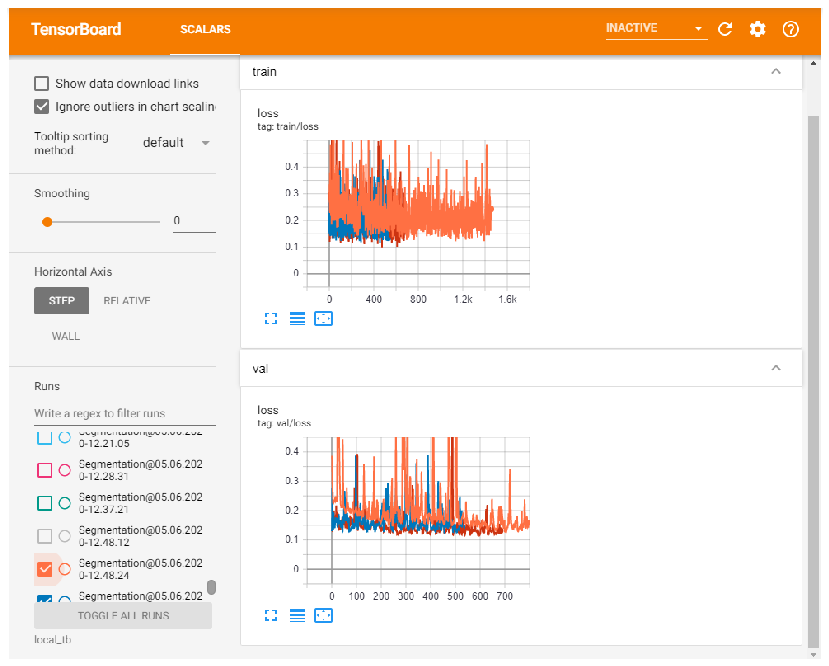

In [36]:
TRAIN = False
if TRAIN:
    %tensorboard --logdir local_tb
else:
    fig = plt.figure(figsize=(16,12))
    im = io.imread('misc\screenshots\SegmentationTensorboard.PNG')
    plt.axis('off')
    plt.imshow(im)

In [211]:
if TRAIN:
    epochs = 1
    outer_epochs = 80
    losses = []
    losses_val = []
    best_loss = 200

    schedule_counter = 0
    n_iters = 0
    for e in tqdm(range(outer_epochs)):
        for n in range(epochs):
            for batch in train_loader:
                model.train()
                x, y = batch
                x = x.permute(0,3,1,2)
                x = x.cuda()
                y = y.cuda()
                pred = model(x)
                #loss = composite_loss(pred, y)
                #with torch.autograd.set_detect_anomaly(True):
                loss = loss_ce(pred, y, criterion, criterion2)
                if math.isnan(loss.item()):
                    break
                losses.append(loss.item())
                opt.zero_grad()
                loss.backward()
                opt.step()    
                #scheduler.step()

                # Validation
                with torch.no_grad():
                    model.eval()
                    val_iter = 0
                    loss_val = 0
                    for batch in val_loader:
                        x_val, y_val = batch
                        pred_val = model(x_val.permute(0,3,1,2).cuda())
                        loss_val += loss_ce(pred_val, y_val.cuda(), criterion, criterion2).item()
                        #loss_val = composite_loss(pred_val, y_val.cuda()).item()
                    #loss_val = loss_val / len(val_dataset)
                    losses_val.append(loss_val)
                    # iou_val = calc_iou_torch(pred_val, y_val)

                writer.add_scalar("train/loss", loss.item(), global_step = n_iters)
                writer.add_scalar("val/loss", loss_val, global_step = n_iters)
                # writer.add_scalar("val/iou", loss_val.item(), global_step = n * len(train_loader) + n_iters)
                # if n_iters % 30 == 0:
                #     writer.add_image('train/photo_image', torchvision.utils.make_grid(x) * 0.5 + 0.5, n * len(train_loader) + n_iters)
                #     writer.add_image('train/map_image_prediction', torchvision.utils.make_grid(y_pred), n * len(train_loader) + n_iters)
                #     writer.add_image('train/map_image_groundtruth', torchvision.utils.make_grid(y), n * len(train_loader) + n_iters)
                if (n_iters % 100) == 0:
                    torch.save(model.state_dict(),'segmentations/newSegmentation{}.pth'.format(n_iters))
                if loss_val < best_loss:
                    best_loss = loss_val
                    torch.save(model.state_dict(), 'segmentations/newSegmentationt.pth')
                n_iters += 1
                if (n_iters % 10) == 0:
                    schedule_counter += 1
            model.load_state_dict(torch.load('segmentations/newSegmentationt.pth'))

In [202]:
#model.load_state_dict(torch.load('segmentations/newSegmentation.pth'))
model.load_state_dict(torch.load('final_model_weights\segmentation\Segmentation.79.7.pth'))

<All keys matched successfully>

(-0.5, 511.5, 511.5, -0.5)

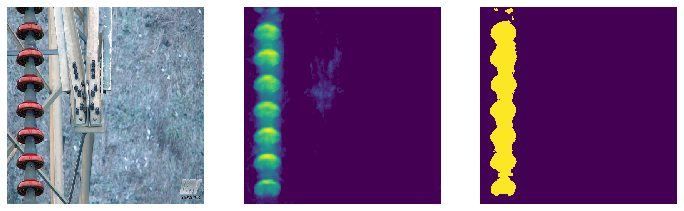

In [210]:
img = val_dataset.__getitem__(2)[0]

fig, axes = plt.subplots(1, 3, figsize = (12,6))

img_in = img.permute(2,0,1).unsqueeze(0).cuda()
pred = model(img_in)
pred_bin = torch.gt(pred, torch.tensor(0.08)).type(torch.float32).permute(1,2,0)[:,:,0].detach().to("cpu")
axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(pred.to('cpu').detach().numpy()[0,:,:])
axes[1].axis('off')
axes[2].imshow(pred_bin.clamp_(0,1))
axes[2].axis('off')

In [205]:
model = UNet().to(device)
model.load_state_dict(torch.load('final_model_weights\segmentation\Segmentation.79.7.pth'))

path1 = sorted(glob.glob(os.path.join(data_path_seg, "val/in/*.jpg")))
path2 = sorted(glob.glob(os.path.join(data_path_seg, "val/gt/*.jpg")))
d = np.zeros(7)

ious = []
ps = np.arange(0,1.02,step = 0.02)

with torch.no_grad():
  model.eval()
  for p in ps:
    preds = []
    gt1 = []

    for j in range(len(val_dataset)):
        image = torch.tensor(cv2.imread(path1[j]),dtype=torch.float32) / 255
        gt = torch.tensor(cv2.imread(path2[j], 0),dtype=torch.float32) / 255
        gt.unsqueeze_(0)
        y = gt
        y.unsqueeze_(0)
        image.unsqueeze_(0)
        x = image.permute(0,3,1,2)
        x = x.cuda()
        s = model(x)
        s = s.detach().cpu()
        s1 = s + 0.0
        s1[s1 < p] = 0
        preds.append(s1)
        gt1.append(y)

    ious.append(calc_iou(preds,gt1))

print('Maximal IoU at: p = {}'.format(ps[np.argmax(ious)]))
print('Maximal IoU: {}'.format(ious[np.argmax(ious)]))
# print(calc_iou(preds,gt1))

Maximal IoU at: p = 0.0
Maximal IoU: 0.8080474138259888


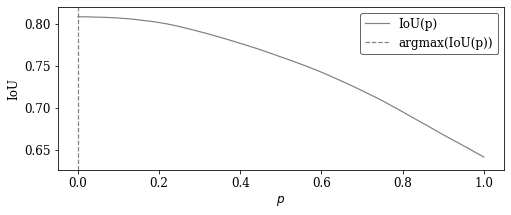

In [321]:
fig, ax = plt.subplots(figsize = (8,3))
plt.xlabel('$p$')
plt.ylabel('IoU')

plt.plot(ps, ious, lw = 1.2, ls = 'solid', color = 'gray', label = "IoU(p)")
plt.ylim(bottom = 0.626, top = 0.82)
plt.axvline(x = ps[np.argmax(ious)], lw = 1.2, ls = 'dashed', color = 'gray', label = "argmax(IoU(p))")

leg = plt.legend(fancybox = True, framealpha = 0.6, edgecolor = 'black', loc = "upper right")

plt.savefig('IoU.pdf', format = 'pdf')

In [18]:
import tensorflow as tf

summaries_root = "summaries/segmentation"
summaries_segmentation = ["Segmentation@05.06.2020-12.37.21", 
                          "Segmentation@05.06.2020-12.48.24", 
                          "Segmentation@05.06.2020-13.18.00"]

def return_event_scalars(path, name_x= "train/loss", name_y = "val/loss"):
    file_path = os.path.join(path, os.listdir(path = path)[0])
    x_values = []
    y_values = []
    for e in tf.python.train.summary_iterator(file_path):
        for v in e.summary.value:
            if v.tag == name_x:
                x_values.append(v.simple_value)
            elif v.tag == name_y:
                y_values.append(v.simple_value)
    return x_values, y_values

logs = []
for s in summaries_segmentation:
    logs.append(return_event_scalars(os.path.join(summaries_root, s)))

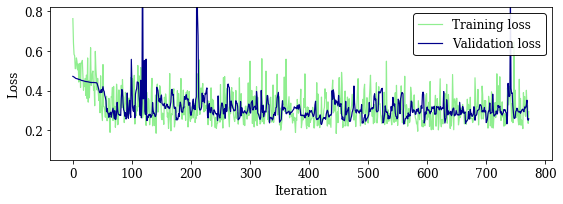

In [340]:
fig, ax = plt.subplots(figsize = (8,3))
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.plot(logs[0][0], lw = 1.2, ls = 'solid', color = 'lightgreen', label = "Training loss")
plt.plot(logs[0][1], lw = 1.2, ls = 'solid', color = 'darkblue', label = "Validation loss")
plt.ylim(bottom = 0.05, top = 0.82)
plt.tight_layout()

leg = plt.legend(fancybox = True, framealpha = 0.9, edgecolor = 'black', loc = "upper right")

plt.savefig('Segmentation1.pdf', format = 'pdf')

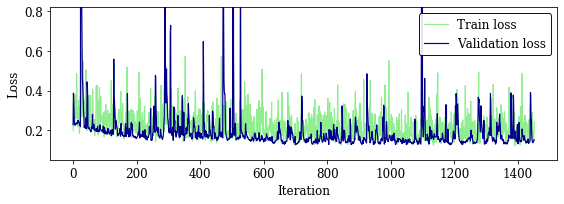

In [341]:
fig, ax = plt.subplots(figsize = (8,3))
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.plot(logs[1][0], lw = 1.2, ls = 'solid', color = 'lightgreen', label = "Train loss")
plt.plot(logs[1][1], lw = 1.2, ls = 'solid', color = 'darkblue', label = "Validation loss")
plt.ylim(bottom = 0.05, top = 0.82)
plt.tight_layout()

leg = plt.legend(fancybox = True, framealpha = 0.9, edgecolor = 'black', loc = "upper right")

plt.savefig('Segmentation2.pdf', format = 'pdf')

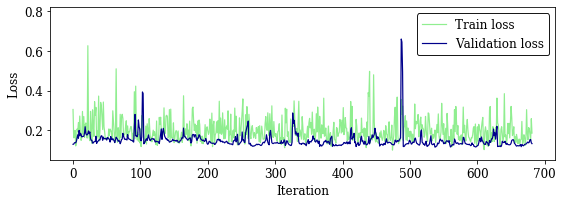

In [339]:
fig, ax = plt.subplots(figsize = (8,3))
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.plot(logs[2][0], lw = 1.2, ls = 'solid', color = 'lightgreen', label = "Training loss")
plt.plot(logs[2][1], lw = 1.2, ls = 'solid', color = 'darkblue', label = "Validation loss")
plt.ylim(bottom = 0.05, top = 0.82)
plt.tight_layout()

leg = plt.legend(fancybox = True, framealpha = 0.9, edgecolor = 'black', loc = "upper right")

plt.savefig('Segmentation3.pdf', format = 'pdf')

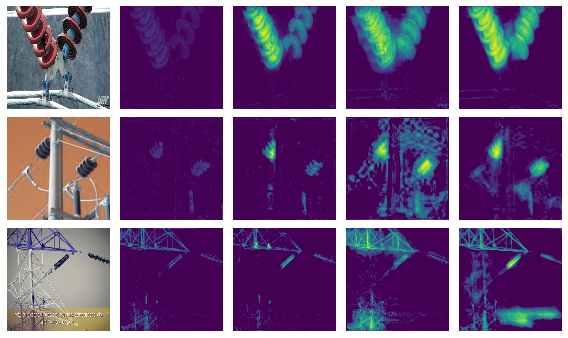

In [213]:
model_root = "misc\intermediate_segmentations"
models = ["newSegmentation100.pth", "newSegmentation300.pth", "newSegmentation1200.pth"]

fig, axes = plt.subplots(3, len(models) + 2, figsize = (8,5))

img1 = val_dataset.__getitem__(8)[0]
img2 = val_dataset.__getitem__(5)[0]
img3 = val_dataset.__getitem__(6)[0]

axes[0, 0].imshow(img1)
axes[0, 0].axis('off')
axes[1, 0].imshow(img2)
axes[1, 0].axis('off')
axes[2, 0].imshow(img3)
axes[2, 0].axis('off')

for i in range(len(models)):
    intermediate_model = UNet().to(device)
    intermediate_model.load_state_dict(torch.load(os.path.join(model_root, models[i])))
    intermediate_model.eval()
    with torch.no_grad():
        pred1 = intermediate_model(img1.permute(2,0,1).unsqueeze(0).cuda())
        pred2 = intermediate_model(img2.permute(2,0,1).unsqueeze(0).cuda())
        pred3 = intermediate_model(img3.permute(2,0,1).unsqueeze(0).cuda())
    axes[0, i + 1].imshow(pred1.permute(1,2,0)[:,:,0].to('cpu'))
    axes[0, i + 1].axis('off')
    axes[1, i + 1].imshow(pred2.permute(1,2,0)[:,:,0].to('cpu'))
    axes[1, i + 1].axis('off')
    axes[2, i + 1].imshow(pred3.permute(1,2,0)[:,:,0].to('cpu'))
    axes[2, i + 1].axis('off')
    
intermediate_model = UNet().to(device)
intermediate_model.load_state_dict(torch.load('final_model_weights\segmentation\Segmentation.79.7.pth'))
intermediate_model.eval()
with torch.no_grad():
    pred1 = intermediate_model(img1.permute(2,0,1).unsqueeze(0).cuda())
    pred2 = intermediate_model(img2.permute(2,0,1).unsqueeze(0).cuda())
    pred3 = intermediate_model(img3.permute(2,0,1).unsqueeze(0).cuda())
axes[0, len(models) + 1].imshow(pred1.permute(1,2,0)[:,:,0].to('cpu'))
axes[0, len(models) + 1].axis('off')
axes[1, len(models) + 1].imshow(pred2.permute(1,2,0)[:,:,0].to('cpu'))
axes[1, len(models) + 1].axis('off')
axes[2, len(models) + 1].imshow(pred3.permute(1,2,0)[:,:,0].to('cpu'))
axes[2, len(models) + 1].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace = -0.05)
fig.savefig('unet_output_training.png', format = 'png', dpi = 600)

# Classification using VGG
---
## Dataset and Dataloader classes

In [211]:
from os.path import join

def class_to_onehot(class_id, class_num):
  out = torch.zeros((1,class_num))
  out[1,class_id] = 1.0
  return out

class ClassDataset(Dataset):
    def __init__(self, transform = None, data_path = "", class_onehot = False):
        self.class_onehot = class_onehot
        self.paths = []
        self.paths_gt = []
        self.root_paths = sorted(glob.glob(join(data_path, "[0-9]*")))
        self.class_num = len(self.root_paths)
        self.path_class_dict = dict()
        class_id = 1
        for class_path in self.root_paths:
          current_paths = sorted(glob.glob(os.path.join(class_path, "*.jpg")))
          current_paths_gt = sorted(glob.glob(os.path.join(class_path, "gt/*.jpg")))
          for i, path in enumerate(current_paths):
            self.paths.append(path)
            self.paths_gt.append(current_paths_gt[i])
            self.path_class_dict[path] = class_id - 1
          class_id += 1

        self.transform = transform

    def __getitem__(self, index):
        sample  = cv2.imread(self.paths[index])
        mask = cv2.imread(self.paths_gt[index])
        sample = sample * mask
        
        if self.transform is not None:
            augmented = self.transform(image = sample)
            sample = torch.tensor(augmented['image'], dtype = torch.float32) / 255

        class_id = self.path_class_dict[self.paths[index]]

        if self.class_onehot:
          target = class_to_onehot(class_id, self.class_num)
        else:
          target = torch.tensor(class_id)
        
        return sample, target

    def __len__(self):
        return len(self.paths)

In [212]:
transform = Compose([ 
    VerticalFlip(p = 0.5),              
    RandomRotate90(p = 0.5),
    # OneOf([
    #     ElasticTransform(p = 0.5, alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03),
    #     GridDistortion(p = 0.5),
    #     OpticalDistortion(p = 1, distort_limit = 2, shift_limit = 0.5)                  
    #     ], p = 0.8),
    CLAHE(p = 0.8),
    RandomBrightnessContrast(p = 0.8),    
    RandomGamma(p = 0.8)])

transform1 = Compose([               
    RandomRotate90(p = 0.0),
  ])

batch_size = 3

class_train_dataset = ClassDataset(transform = transform, data_path = join(data_path_class, "train"))
class_val_dataset = ClassDataset(transform = transform1, data_path = join(data_path_class, "val"))
class_train_loader = DataLoader(class_train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
class_train_loader_no_shuffle = DataLoader(class_train_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)
class_train_loader_full = DataLoader(class_train_dataset, batch_size = len(class_train_dataset), shuffle = False, num_workers = 0)
class_train_loader_quad = DataLoader(class_train_dataset, batch_size = int(np.ceil(len(class_train_dataset) / 4)), shuffle = False, num_workers = 0)
class_val_loader = DataLoader(class_val_dataset, batch_size = len(class_val_dataset), shuffle = False, num_workers = 0)

In [213]:
class VggDownBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, pooling = True, num_conv = 1, pool_kernel = 4, init = None):
        super().__init__()
        
        self.num_conv = num_conv
        self.init = init

        self.convReLU = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )

        # self.convReLU2 = nn.Sequential(
        #     nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU(inplace = True),
        #     nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU()
        # )

        # self.convReLU3 = nn.Sequential(
        #     nn.Conv2d(in_channels, mid_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU(),
        #     nn.Conv2d(mid_channels, mid_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU(),
        #     nn.Conv2d(mid_channels, out_channels, kernel_size = 3, padding = 1),
        #     nn.ReLU()
        # )

        self.maxpool = nn.MaxPool2d(kernel_size = pool_kernel)
        
    def forward(self, seq):
        # B, C, H, W

        assert self.num_conv == 1, self.num_conv == 2 or self.num_conv == 3
        if self.init != None:
            self.convReLU[0].weight.data.fill_(self.init)
            self.convReLU[1].weight.data.fill_(self.init)
            self.convReLU[3].weight.data.fill_(self.init)
            self.convReLU[4].weight.data.fill_(self.init)
        
        if self.num_conv == 1:
            seq = self.convReLU(seq)
#         elif self.num_conv == 2:
#           seq = self.convReLU2(seq)
#         elif self.num_conv == 3:
#           seq = self.convReLU3(seq)

        seq = self.maxpool(seq)

        return seq

class VGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        nb = 8
        init_val = None

        self.downBlocks = nn.ModuleList()
        self.downBlocks.append(VggDownBlock(3, 3, nb, pool_kernel = 2, init = init_val))
        self.downBlocks.append(VggDownBlock(nb, nb, nb * 2, pool_kernel = 4, init = init_val))
        self.downBlocks.append(VggDownBlock(nb * 2, nb * 2, nb * 4, pool_kernel = 2, init = init_val))
        self.downBlocks.append(VggDownBlock(nb * 4, nb * 4, nb * 8, pool_kernel = 4, init = init_val))
        self.downBlocks.append(VggDownBlock(nb * 8, nb * 8, nb * 16, pool_kernel = 2, init = init_val))
        self.downBlocks.append(VggDownBlock(nb * 16, nb * 4, nb * 32, pool_kernel = 2, init = init_val))

        dims_flatten = (512 / (2 ** (len(self.downBlocks) + 2))) ** 2 * (nb * 32)

        self.finalBlock = nn.Sequential(nn.Flatten(),
                                     #nn.BatchNorm1d(int(dims_flatten)),
                                     nn.Linear(int(dims_flatten), 800),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(800, num_classes))
                                     #nn.BatchNorm1d(int(num_classes)))

        self.initBN = nn.BatchNorm2d(3)
      
    def forward(self, input):

        for db in self.downBlocks:
            input = db(input)

        input = self.finalBlock(input)

        return input

In [214]:
# im = class_val_dataset.__getitem__(0)[0]
# plt.imshow(im)

criterion = nn.CrossEntropyLoss()
cm = VGG(class_train_dataset.class_num).cuda()
#cm.load_state_dict(torch.load('ClassifierStage2.pth'))
#cm.load_state_dict(torch.load('ClassifierStage2.pth'))

In [84]:
# %reset
# import torch
# torch.cuda.empty_cache()

In [238]:
#opt = torch.optim.Adam(cm.parameters(), lr = 0.0000065, amsgrad = True)
#opt = torch.optim.SGD(cm.parameters(), lr = 0.001, momentum = 0.82, nesterov = True, weight_decay = 0.002)
#opt = torch.optim.SGD(cm.parameters(), lr = 0.0076, momentum = 0.72, nesterov = True, weight_decay = 0.002)
opt = torch.optim.SGD(cm.parameters(), lr = 0.0008, momentum = 0.26, nesterov = True, weight_decay = 0.002)
#opt = torch.optim.Adamax(cm.parameters(), lr=0.000002, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.001)

lmbda = lambda epoch: 0.98
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lmbda)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
experiment_title='Classification'
if os.name == 'nt':
    experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
else:
    experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("./local_tb", experiment_name))

experiment_name: Classification@06.06.2020-05.46.09


In [70]:
#!taskkill /F /PID 908
#%load_ext tensorboard

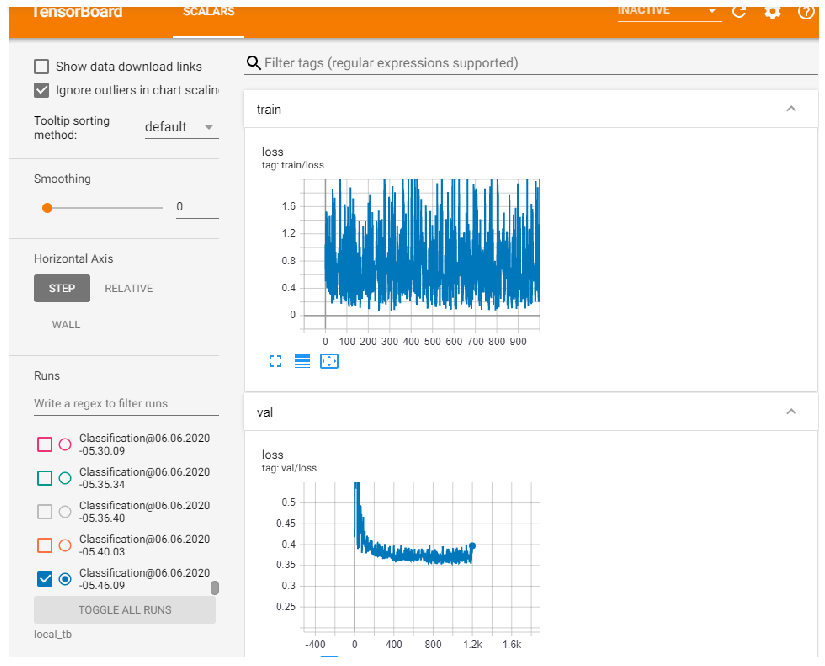

In [37]:
TRAIN = False
if TRAIN:
    %tensorboard --logdir local_tb
else:
    fig = plt.figure(figsize=(16,12))
    im = io.imread('misc\screenshots\ClassifierTensorboard.PNG')
    plt.axis('off')
    plt.imshow(im)

In [239]:
epochs = 2
outer_epochs = 40
losses = []
losses_val = []
losses_train = []
best_loss = 200

opt_update = False
n_iters = 0
for n in tqdm(range(outer_epochs)):
    for e in range(epochs):
        for batch in class_train_loader:
            cm.train()
            # if n_iters == 1:
            #   batch = next(iter(class_train_loader_full))
            x, y = batch
            x = x.permute(0,3,1,2)
            x = x.cuda()
            y = y.cuda()
            pred = cm(x)
            loss = criterion(pred, y)
            if math.isnan(loss.item()):
                break
            losses.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()    
            scheduler.step()

            # Validation
            with torch.no_grad():
                cm.eval()
                x_val, y_val = next(iter(class_val_loader))
                pred_val = cm(x_val.permute(0,3,1,2).cuda())
                loss_val = criterion(pred_val, y_val.cuda())
                      # iou_val = calc_iou_torch(pred_val, y_val)

            writer.add_scalar("train/loss", loss.item(), global_step = n_iters)
            writer.add_scalar("val/loss", loss_val.item(), global_step = n_iters)
            losses_train.append(loss.item())
            losses_val.append(loss_val.item())
            # writer.add_scalar("val/iou", loss_val.item(), global_step = n * len(class_train_loader) + n_iters)
            # if n_iters % 30 == 0:
            #     writer.add_image('train/photo_image', torchvision.utils.make_grid(x) * 0.5 + 0.5, n * len(train_loader) + n_iters)
            #     writer.add_image('train/map_image_prediction', torchvision.utils.make_grid(y_pred), n * len(train_loader) + n_iters)
            #     writer.add_image('train/map_image_groundtruth', torchvision.utils.make_grid(y), n * len(train_loader) + n_iters)
            n_iters += 1
            if loss_val < best_loss:
                best_loss = loss_val
                #torch.save(cm.state_dict(),'ClassifierStage1.pth')
                torch.save(cm.state_dict(),'Classifier_new.pth')
            if n == 10:
                if not opt_update:
                    #opt = torch.optim.SGD(cm.parameters(), lr = 0.00008, momentum = 0.17, nesterov = True, weight_decay = 0.002)
                    opt = torch.optim.Adamax(cm.parameters(), lr=0.000002, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.001)
                    opt_update = True
        cm.load_state_dict(torch.load('Classifier_new.pth'))

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [05:56<00:00,  8.91s/it]


In [242]:
#torch.save(cm.state_dict(), 'Classifier_new2.pth')

In [215]:
cm.load_state_dict(torch.load('final_model_weights\classifier\Classifier.pth'))
cm.eval()
sm = nn.Softmax(dim = 1)
x_val, y_val = next(iter(class_val_loader))
pred_val = sm(cm(x_val.permute(0,3,1,2).cuda())).argmax(dim = 1).to("cpu")

In [216]:
assert len(pred_val) == len(y_val)
correct = 0
total = 0
for i in range(0, len(pred_val)):
    if torch.equal(pred_val[i], y_val[i].to("cpu")):
        total += 1
        correct += 1
    else:
        total += 1
print("CCR: ",correct/total)

CCR:  0.9285714285714286


In [343]:
summaries_root = "summaries/classifier"
summaries_classifier = ["Classification@06.06.2020-05.46.09"]
losses_train, losses_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[0]))

In [344]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
rcParams['font.size'] = 12

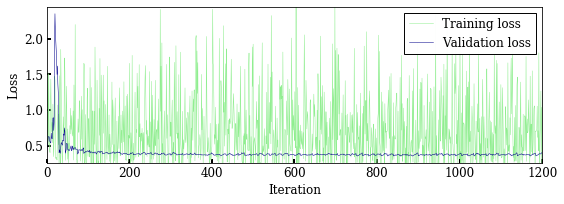

In [345]:
fig, ax = plt.subplots(figsize = (8, 3), frameon = False)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
#ax.set_yscale("log")
ax.set_xlim(left = 0.0, right = 1200)
ax.set_ylim(bottom = 0.25, top = 2.45)
ax.plot(losses_train, lw = 0.5, ls = 'solid', color = 'lightgreen', label = 'Training loss')
ax.plot(losses_val, lw = 0.5, ls = 'solid', color = 'darkblue', label = 'Validation loss')
ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
leg = plt.legend(fancybox = False, framealpha = 0.98, edgecolor = 'black', loc = "upper right")
plt.tight_layout()
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig.savefig('VggLoss_final.pdf', format = 'pdf')

# Fault detection algorithm
---

In [46]:
from os.path import join

def class_to_onehot(class_id, class_num):
    out = torch.zeros((1,class_num))
    out[1,class_id] = 1.0
    return out

class FdDataset(Dataset):
    def __init__(self, transform = None, data_path = "", class_onehot = False):
        self.class_onehot = class_onehot
        self.paths = []
        self.root_paths = sorted(glob.glob(join(data_path, "[0-9]*")))
        self.class_num = len(self.root_paths)
        self.path_class_dict = dict()
        class_id = 1
        for class_path in self.root_paths:
            current_paths = sorted(glob.glob(os.path.join(class_path, "*.jpg")))
            for i, path in enumerate(current_paths):
                self.paths.append(path)
                self.path_class_dict[path] = class_id - 1
            class_id += 1

        self.transform = transform

    def __getitem__(self, index):
        sample  = torch.tensor(cv2.imread(self.paths[index]), dtype = torch.float32) / 255
        class_id = self.path_class_dict[self.paths[index]]

        if self.class_onehot:
          target = class_to_onehot(class_id, self.class_num)
        else:
          target = torch.tensor(class_id)
        
        return sample, target

    def __len__(self):
        return len(self.paths)

In [373]:
#### torch.cuda.empty_cache()

final_train_dataset = FdDataset(transform = None, data_path = join(data_path_class, "train"))
final_val_dataset = FdDataset(transform = None, data_path = join(data_path_class, "val"))
final_train_loader = DataLoader(final_train_dataset, batch_size = 5, shuffle = False, num_workers = 0)
final_val_loader = DataLoader(final_val_dataset, batch_size = 5, shuffle = False, num_workers = 0)

segmentation = UNet().to(device).eval()
segmentation.load_state_dict(torch.load('final_model_weights/segmentation/Segmentation.79.7.pth'))
p = 0.42

classifier = VGG(final_val_dataset.class_num).cuda().eval()#PClassifierNoPreR

#classifier.load_state_dict(torch.load('final_model_weights/pClassifier/pClassifierPreR.pth')) #0.7857
#classifier.load_state_dict(torch.load('final_model_weights/pClassifier/pClassifierPreAlt.pth')) #0.71
#classifier.load_state_dict(torch.load('final_model_weights/pClassifier/pClassifierNoPreR.pth')) #0.5
#classifier.load_state_dict(torch.load('final_model_weights/pClassifier/pClassifierNoPreNoR.pth')) #0.42
#classifier.load_state_dict(torch.load('final_model_weights/classifier/Classifier.pth')) #0.21

softmax = nn.Softmax(dim = 1)
batchnorm = nn.BatchNorm2d(3).cuda()

# Fault detection algorithm
def fault_detection(x):
    x = x.cuda().permute(0,3,1,2)
    x_seg = segmentation(x)
    x_mask = torch.gt(x_seg, p).type(torch.float32)
    product = x_mask.unsqueeze(1).repeat(1,3,1,1).mul_(x)
    class_prediction = softmax(classifier(batchnorm(product))).argmax(dim = 1).to("cpu")
    return class_prediction

In [374]:
# Test
#-----

correct = 0
total = 0

with torch.no_grad():
    for batch in final_val_loader:
        x, y = batch
        prediction = fault_detection(x)

        assert len(prediction) == len(y)
        for i in range(0, len(prediction)):
            if torch.equal(prediction[i], y[i].to("cpu")):
                total += 1
                correct += 1
            else:
                total += 1

#     for batch in final_train_loader:
#         x, y = batch
#         prediction = fault_detection(x)

#         assert len(prediction) == len(y)
#         for i in range(0, len(prediction)):
#           if torch.equal(prediction[i], y[i].to("cpu")):
#             total += 1
#             correct += 1
#           else:
#             total += 1

print("CCR: ", correct / total)

CCR:  0.21428571428571427


In [239]:
class PipeDataset(Dataset):
    def __init__(self, transform = None, data_path = "", class_onehot = False):
        self.class_onehot = class_onehot
        self.paths = []
        self.root_paths = sorted(glob.glob(join(data_path, "[0-9]*")))
        self.class_num = len(self.root_paths)
        self.path_class_dict = dict()
        class_id = 1
        for class_path in self.root_paths:
            current_paths = sorted(glob.glob(os.path.join(class_path, "*.jpg")))
            for i, path in enumerate(current_paths):
                self.paths.append(path)
                self.path_class_dict[path] = class_id - 1
            class_id += 1

        self.transform = transform
        self.segmentation = UNet().to(device).eval()
        self.segmentation.load_state_dict(torch.load('final_model_weights/segmentation/Segmentation.79.7.pth'))

    def __getitem__(self, index):
        sample = cv2.imread(self.paths[index])
           
        if self.transform is not None:
            augmented = self.transform(image = sample)
            sample = torch.tensor(augmented['image'], dtype = torch.float32) / 255
        
        sample = sample.permute(2,0,1).unsqueeze(0).cuda()
        with torch.no_grad():
            mask = torch.gt(self.segmentation(sample), 0.0).type(torch.float32)
        sample = mask.unsqueeze(1).repeat(1,3,1,1).mul_(sample)
        sample = sample.permute(0,2,3,1).squeeze(0)
        
        class_id = self.path_class_dict[self.paths[index]]

        if self.class_onehot:
          target = class_to_onehot(class_id, self.class_num)
        else:
          target = torch.tensor(class_id)
        
        return sample, target

    def __len__(self):
        return len(self.paths)
    
transform = Compose([ 
    VerticalFlip(p = 0.5),              
    RandomRotate90(p = 0.5),
    # OneOf([
    #     ElasticTransform(p = 0.5, alpha = 120, sigma = 120 * 0.05, alpha_affine = 120 * 0.03),
    #     GridDistortion(p = 0.5),
    #     OpticalDistortion(p = 1, distort_limit = 2, shift_limit = 0.5)                  
    #     ], p = 0.8),
    CLAHE(p = 0.8),
    RandomBrightnessContrast(p = 0.8),    
    RandomGamma(p = 0.8)])

transform1 = Compose([               
    RandomRotate90(p = 0.0),
  ])

batch_size = 3

pipe_train_dataset = PipeDataset(transform = transform, data_path = join(data_path_class, "train"))
pipe_val_dataset = PipeDataset(transform = transform1, data_path = join(data_path_class, "val"))
pipe_train_loader = DataLoader(pipe_train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0)
pipe_val_loader = DataLoader(pipe_val_dataset, batch_size = len(pipe_val_dataset), shuffle = False, num_workers = 0)

In [313]:
criterion = nn.CrossEntropyLoss()
fcm = VGG(pipe_train_dataset.class_num).cuda()
#fcm.load_state_dict(torch.load('final_model_weights/classifier/Classifier.pth'))
#fcm.load_state_dict(torch.load('final_model_weights/pClassifier/pClassifierR.pth'))
#fcm.load_state_dict(torch.load('PClassifier1.pth'))

#opt = torch.optim.Adamax(fcm.parameters(), lr=0.0000001, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.001)
opt = torch.optim.SGD(fcm.parameters(), lr = 0.0082, momentum = 0.2, weight_decay = 0.001, nesterov = True)
#opt = torch.optim.SGD(fcm.parameters(), lr = 0.0008, momentum = 0.26, nesterov = True, weight_decay = 0.002)
#opt = torch.optim.Adam(fcm.parameters(), lr = 0.0000021, amsgrad = True, weight_decay = 0.001)

#R 0.8
lmbda = lambda epoch: 0.86
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lmbda)

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
experiment_title='PClassification'
if os.name == 'nt':
    experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
else:
    experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print('experiment_name:', experiment_name)
writer = SummaryWriter(log_dir=os.path.join("./local_tb", experiment_name))

#%load_ext tensorboard

experiment_name: PClassification@07.06.2020-07.38.48


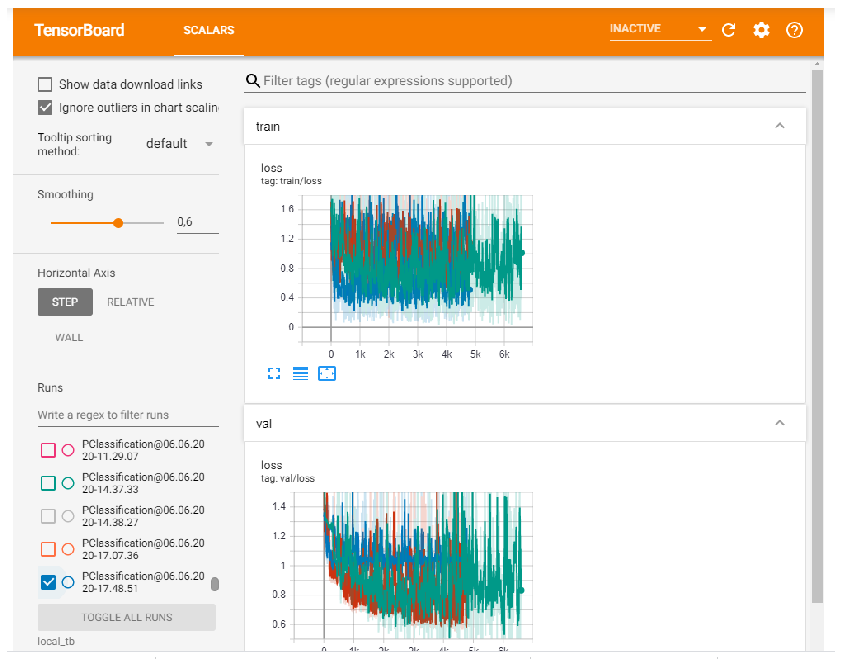

In [317]:
TRAIN = False
if TRAIN:
    %tensorboard --logdir local_tb
else:
    fig = plt.figure(figsize=(16,12))
    im = io.imread('misc\screenshots\pClassifierTensorboard.PNG')
    plt.axis('off')
    plt.imshow(im)

In [315]:
if TRAIN:
    epochs = 2
    outer_epochs = 160
    losses = []
    losses_val = []
    losses_train = []
    best_loss = 200
    last_loss_val = 0
    state_repo = 'PClassifierNoPreNoR.pth'
    torch.save(fcm.state_dict(), state_repo)
    with torch.no_grad():
        fcm.eval()
        x_val, y_val = next(iter(pipe_val_loader))
        pred_val = fcm(x_val.permute(0,3,1,2).cuda())
        loss_val = criterion(pred_val, y_val.cuda())
        best_loss = loss_val.item()
    print("Initial loss: ", best_loss)

    alternating_optimizers_enabled = False
    reset_enabled = False
    opt_switch = False
    n_iters = 0
    valsubset = False

    for n in tqdm(range(outer_epochs)):
        #pipe_train_loader = DataLoader(pipe_train_dataset, batch_size = e + 1, shuffle = True, num_workers = 0)
        for e in range(0, epochs): #tqdm(range(epochs)):
            for batch in pipe_train_loader:
                fcm.train()
                x, y = batch
                x = x.permute(0,3,1,2)
                x = x.cuda()
                y = y.cuda()
                pred = fcm(x)
                loss = criterion(pred, y)
                if math.isnan(loss.item()):
                    break
                losses.append(loss.item())
                opt.zero_grad()
                loss.backward()
                opt.step()

                if n_iters % 20:
                    scheduler.step()

                # Validation
                with torch.no_grad():
                    fcm.eval()
                    sum_loss = 0.0
                    if not valsubset:
                        fcm.eval()
                        x_val, y_val = next(iter(pipe_val_loader))
                        pred_val = fcm(x_val.permute(0,3,1,2).cuda())
                        loss_val = criterion(pred_val, y_val.cuda())
                    else:
                        for val_batch in pipe_val_loader:
                            x_val, y_val = val_batch
                            pred_val = fcm(x_val.permute(0,3,1,2).cuda())
                            loss_val = criterion(pred_val, y_val.cuda())
                            sum_loss += loss_val
                        sum_loss /= len(pipe_val_dataset)
                        loss_val = sum_loss

                global_step = n_iters #e * epochs * len(pipe_train_loader) + n * len(pipe_train_loader) + n_iters
                
                writer.add_scalar("train/loss", loss.item(), global_step = global_step)
                writer.add_scalar("val/loss", loss_val.item(), global_step = global_step)
                losses_train.append(loss.item())
                losses_val.append(loss_val.item())
                # writer.add_scalar("val/iou", loss_val.item(), global_step = n * len(class_train_loader) + n_iters)
                # if n_iters % 30 == 0:
                #     writer.add_image('train/photo_image', torchvision.utils.make_grid(x) * 0.5 + 0.5, n * len(train_loader) + n_iters)
                #     writer.add_image('train/map_image_prediction', torchvision.utils.make_grid(y_pred), n * len(train_loader) + n_iters)
                #     writer.add_image('train/map_image_groundtruth', torchvision.utils.make_grid(y), n * len(train_loader) + n_iters)
                n_iters += 1

                # if loss_val < last_loss_val and loss_val < 0.6 and e == 0:
                    # torch.save(fcm.state_dict(), state_repo)

                last_loss_val = loss_val
                if loss_val < best_loss:
                    best_loss = loss_val
                    torch.save(fcm.state_dict(), state_repo)

                if reset_enabled:
                    if n_iters % 300 == 0:
                        opt = torch.optim.SGD(fcm.parameters(), lr = 0.0075, momentum = 0.2, weight_decay = 0.001, nesterov = True)

        fcm.load_state_dict(torch.load(state_repo))

        if alternating_optimizers_enabled:
            if opt_switch:
                opt = torch.optim.SGD(fcm.parameters(), lr = 0.0075, momentum = 0.2, weight_decay = 0.001, nesterov = True)
                opt_switch = False
            else:
                opt = torch.optim.SGD(fcm.parameters(), lr = 0.0009, momentum = 0.17, weight_decay = 0.001, nesterov = True)
                opt_switch = True

  0%|                                                                                          | 0/160 [00:00<?, ?it/s]

Initial loss:  1.3883031606674194


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [29:32<00:00, 11.08s/it]


In [347]:
summaries_root = "summaries/pClassifier"
summaries_classifier = ["PClassification@06.06.2020-08.49.40",
                        "PClassification@06.06.2020-17.48.51", 
                        "PClassification@06.06.2020-09.46.51",
                        "PClassification@06.06.2020-10.38.04"]

summaries_name = ["Pretrained, Reset", "Not Pretrained, Reset", "Not Pretrained, No Reset", "Pretrained, Alternating"]

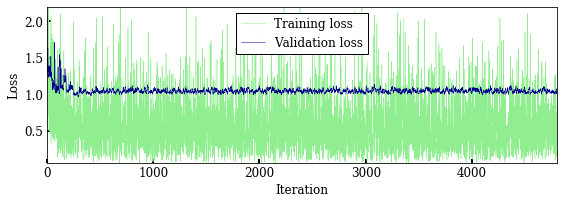

In [333]:
# Not Pretrained, Reset
#----------------------

losses_train, losses_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[2]))

fig, ax = plt.subplots(figsize = (8,3), frameon = False)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(bottom = 0.05, top = 2.2)
ax.set_xlim(left = 0.0, right = 4800)
ax.plot(losses_train, lw = 0.5, ls = 'solid', color = 'lightgreen', label = 'Training loss')
ax.plot(losses_val, lw = 0.5, ls = 'solid', color = 'darkblue', label = 'Validation loss')
ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
leg = plt.legend(fancybox = False, framealpha = 0.98, edgecolor = 'black', loc = "upper center")
plt.tight_layout()
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig.savefig('notPretrainedNoReset_final.pdf', format = 'pdf')

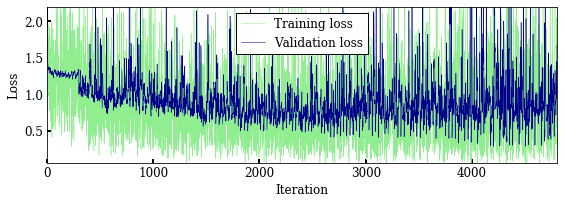

In [348]:
# Pretrained, Reset
#------------------

losses_train, losses_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[0]))

fig, ax = plt.subplots(figsize = (8,3), frameon = False)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(bottom = 0.05, top = 2.2)
ax.set_xlim(left = 0.0, right = 4800)
ax.plot(losses_train, lw = 0.5, ls = 'solid', color = 'lightgreen', label = 'Training loss')
ax.plot(losses_val, lw = 0.5, ls = 'solid', color = 'darkblue', label = 'Validation loss')
ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
leg = plt.legend(fancybox = False, framealpha = 0.98, edgecolor = 'black', loc = "upper center")
plt.tight_layout()
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig.savefig('PretrainedReset_final.pdf', format = 'pdf')

In [335]:
pre_R, pre_R_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[0]))
noPre_R, noPre_R_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[1]))
pre_noR, pre_noR_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[2]))
pre_Alt, pre_Alt_val = return_event_scalars(os.path.join(summaries_root, summaries_classifier[3]))

def incumbent(time_series):
    out = []
    inc = np.max(time_series)
    for val in time_series:
        if val < inc:
            out.append(val)
            inc = val
        else:
            out.append(inc)
    return out
            
inc_pre_R = incumbent(pre_R_val)
inc_noPre_R = incumbent(noPre_R_val)
inc_pre_noR = incumbent(pre_noR_val)
inc_pre_Alt = incumbent(pre_Alt_val)

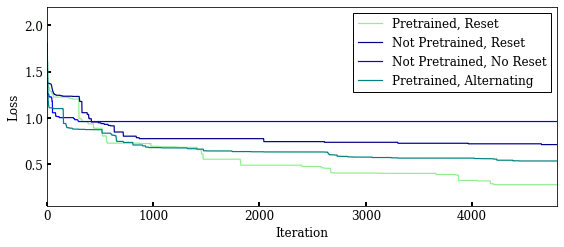

In [336]:
# Optimization methods
#---------------------

fig, ax = plt.subplots(figsize = (8, 3.6), frameon = False)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_ylim(bottom = 0.05, top = 2.2)
ax.set_xlim(left = 0.0, right = 4800)
ax.plot(inc_pre_R, lw = 1.2, ls = 'solid', color = 'lightgreen', label = summaries_name[0])
ax.plot(inc_noPre_R, lw = 1.2, ls = 'solid', color = 'darkblue', label = summaries_name[1])
ax.plot(inc_pre_noR, lw = 1.2, ls = 'solid', color = 'blue', label = summaries_name[2])
ax.plot(inc_pre_Alt, lw = 1.2, ls = 'solid', color = 'teal', label = summaries_name[3])
# ax.plot(losses_val, lw = 0.5, ls = 'solid', color = 'darkblue', label = 'Validation loss')
# ax.plot(losses_train, lw = 0.5, ls = 'solid', color = 'lightgreen', label = 'Train loss')
# ax.plot(losses_val, lw = 0.5, ls = 'solid', color = 'darkblue', label = 'Validation loss')
ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
leg = plt.legend(fancybox = False, framealpha = 0.98, edgecolor = 'black', loc = "upper right")
plt.tight_layout()
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())

fig.savefig('pClass_Opt.pdf', format = 'pdf')

In [301]:
# fig, ax = plt.subplots(figsize = (8,4))
# #ax.set_title('Loss, classifier training')
# plt.xlabel('Iteration')
# plt.ylabel('CE loss')
# plt.yscale("log")
# plt.ylim(bottom = 0.6, top = 2.05)
# plt.plot(losses_train[0:600], lw = 1.2, ls = 'dotted', color = 'gray', label = 'Training loss')
# plt.plot(losses_val[0:600], lw = 1.2, ls = 'solid', color = 'orange', label = 'Validation loss')
# ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
# leg = plt.legend(fancybox = True, framealpha = 0.5, edgecolor = 'black', loc = "upper right")
# # leg = plt.legend()
# # leg.get_frame().set_edgecolor('b')
# plt.savefig('PipeLoss4.pdf', format = 'pdf')
#torch.save(fcm.state_dict(),'PipeClassifier2.pth')

In [302]:
# %reset
# import torch
# torch.cuda.empty_cache()

# Appendix
---

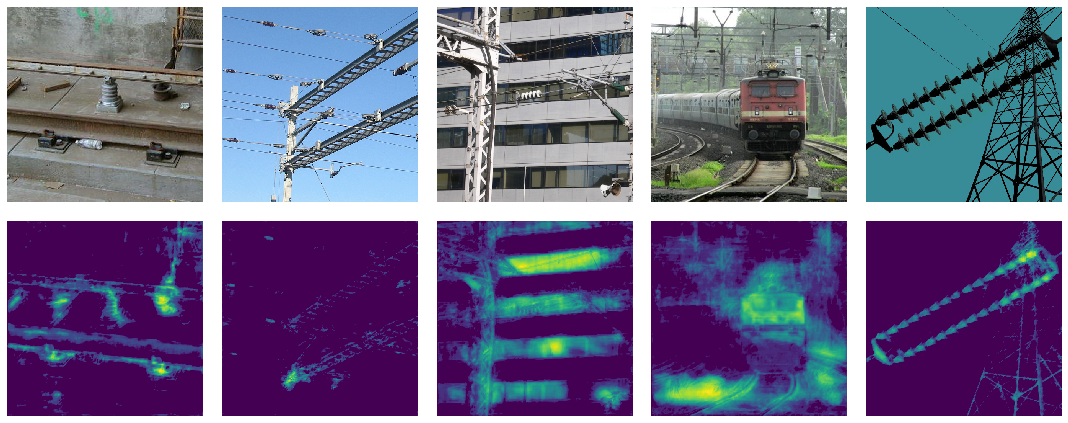

In [283]:
figs_root = "misc/additional_validation"
figs = ["train1.jpg", "train2.jpg", "train3.jpg", "train4.jpg", "power1.jpg"]

fig, axes = plt.subplots(2, 5, figsize = (15,6.3))

img1 = io.imread(os.path.join(figs_root, figs[0]))
img2 = io.imread(os.path.join(figs_root, figs[1]))
img3 = io.imread(os.path.join(figs_root, figs[2]))
img4 = io.imread(os.path.join(figs_root, figs[3]))
img5 = io.imread(os.path.join(figs_root, figs[4]))#[:,:,0:3]

axes[0, 0].imshow(img1)
axes[0, 0].axis('off')
axes[0, 1].imshow(img2)
axes[0, 1].axis('off')
axes[0, 2].imshow(img3)
axes[0, 2].axis('off')
axes[0, 3].imshow(img4)
axes[0, 3].axis('off')
axes[0, 4].imshow(img5)
axes[0, 4].axis('off')
    
intermediate_model = UNet().to(device)
intermediate_model.load_state_dict(torch.load('final_model_weights\segmentation\Segmentation.79.7.pth'))
intermediate_model.eval()
with torch.no_grad():
    pred1 = intermediate_model(torch.tensor(img1 / 255).type(torch.float32).permute(2,0,1).unsqueeze(0).cuda())
    pred2 = intermediate_model(torch.tensor(img2 / 255).type(torch.float32).permute(2,0,1).unsqueeze(0).cuda())
    pred3 = intermediate_model(torch.tensor(img3 / 255).type(torch.float32).permute(2,0,1).unsqueeze(0).cuda())
    pred4 = intermediate_model(torch.tensor(img4 / 255).type(torch.float32).permute(2,0,1).unsqueeze(0).cuda())
    pred5 = intermediate_model(torch.tensor(img5 / 255).type(torch.float32).permute(2,0,1).unsqueeze(0).cuda())
axes[1, 0].imshow(pred1.permute(1,2,0)[:,:,0].to('cpu'))
axes[1, 0].axis('off')
axes[1, 1].imshow(pred2.permute(1,2,0)[:,:,0].to('cpu'))
axes[1, 1].axis('off')
axes[1, 2].imshow(pred3.permute(1,2,0)[:,:,0].to('cpu'))
axes[1, 2].axis('off')
axes[1, 3].imshow(pred4.permute(1,2,0)[:,:,0].to('cpu'))
axes[1, 3].axis('off')
axes[1, 4].imshow(pred5.permute(1,2,0)[:,:,0].to('cpu'))
axes[1, 4].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace = -0.0)
fig.savefig('additional validation.png', format = 'png', dpi = 600)

# The last image is from out data set

In [0]:
# # Random search
# torch.cuda.empty_cache()

# iterations = 5
# initialization_loss = []
# initialization_loss_iter = []
# initialization_loss_v = []
# initialization_loss_v_iter = []
# criterion = nn.CrossEntropyLoss()
# epochs = [1,2,3]
# lims = [l for l in range(0,10)]

# for lim in lims:
#     n_iters = 0
#     for i in range(0, iterations):
#         n_iters = -1
#         icm = VGG(class_train_dataset.class_num).cuda()
#         xv, yv = next(iter(class_val_loader))
#         search_opt = torch.optim.SGD(icm.parameters(), lr = 0.0076, momentum = 0.72, nesterov = True, weight_decay = 0.002)
#         for e in epochs:
#             for batch in class_train_loader:
#                 n_iters += 1
#                 icm.train()
#                 x, y = batch
#                 x = x.cuda().permute(0,3,1,2)
#                 y = y.cuda()
#                 pred = icm(x)
#                 loss = criterion(pred, y)
#                 if n_iters == 0:
#                     initialization_loss.append(loss.item())
#                     initialization_loss_v.append(criterion(icm(xv.permute(0,3,1,2).cuda()), yv.cuda()).item())
#                 search_opt.zero_grad()
#                 loss.backward()
#                 search_opt.step()
#                 icm.eval()
#                 pred = icm(x)
#                 loss = criterion(pred, y)
#                 loss_sum += loss.item()
#                 if n_iters == lim:
#                     initialization_loss_iter.append(criterion(icm(x), y).item())
#                     initialization_loss_v_iter.append(criterion(icm(xv.permute(0,3,1,2).cuda()), yv.cuda()).item())
#                     break
#             if n_iters == lim:
#                 break

#     # print(initialization_loss)
#     # print(initialization_loss_iter)
#     # print(initialization_loss_v)
#     # print(initialization_loss_v_iter)

#     fig, ax = plt.subplots(figsize = (5,4))
#     plt.xlabel('Iteration')
#     plt.ylabel('CE loss')
#     idx = [str(s) for s in range(0, len(initialization_loss))]
#     plt.plot(idx, initialization_loss, lw = 0.0, ls = 'dotted', marker = "+", ms = 4, color = 'black', label = 'Initialization loss, train')
#     plt.plot(idx, initialization_loss_iter, lw = 0.0, ls = 'solid', marker = "o", ms = 4, color = 'black', label = 'Initialization loss, 1e')
#     plt.plot(idx, initialization_loss_v, lw = 0.0, ls = 'dotted', marker = "+", ms = 4, color = 'orange', label = 'Initialization loss, val')
#     plt.plot(idx, initialization_loss_v_iter, lw = 0.0, ls = 'solid', marker = "o", ms = 4, color = 'orange', label = 'Initialization loss, val, 1e')
#     ax.tick_params(direction='in', length = 4, width = 2, colors = 'black', grid_color = 'black', grid_alpha = 0.5)
#     leg = plt.legend(fancybox = True, framealpha = 0.8, edgecolor = 'black', loc = "upper right")
#     plt.savefig('init_losses/InitLosses{}.pdf'.format(n_iters), format = 'pdf')